In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,cross_val_score,StratifiedKFold,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use("seaborn")
import warnings

warnings.filterwarnings("ignore")

In [2]:
train_data=pd.read_csv("train.csv")

train_raw=train_data


In [32]:

test_data=pd.read_csv("test.csv")
test_raw=test_data


|Variable|Definition|
|---|---|
|ID|Question ID|
|Tag|Anonymised tags representing question category|
|Reputation|score of question author|
|Answers|Number of times question has been answered|
|Username|Anonymised user id of question author|
|Views|Number of times question has been viewed|
|Upvotes|(Target) Number of upvotes for the question|

In [4]:
train_data.head()
print("Observations: {}\nFeatures:{}\n\n".format(train_data.shape[0],train_data.shape[1]))
print(train_data.head())

Observations: 330045
Features:7


       ID Tag  Reputation  Answers  Username  Views  Upvotes
0   52664   a        3942        2    155623   7855       42
1  327662   a       26046       12     21781  55801     1175
2  468453   c        1358        4     56177   8067       60
3   96996   a         264        3    168793  27064        9
4  131465   c        4271        4    112223  13986       83


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
ID            330045 non-null int64
Tag           330045 non-null object
Reputation    330045 non-null int64
Answers       330045 non-null int64
Username      330045 non-null int64
Views         330045 non-null int64
Upvotes       330045 non-null int64
dtypes: int64(6), object(1)
memory usage: 17.6+ MB


#### Target variable= Upvotes

#### Independent Variables

In [6]:
ind_var=list(train_data.drop(["Upvotes"],axis=1).columns)
print("Independent Variables: {}".format(ind_var))

Independent Variables: ['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views']


In [7]:
train_data.describe()

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [8]:
train_data["ID"].nunique()

330045

ID is a unique Variable and it can be removed from Analysis

In [9]:
train_data["Username"].nunique()

141802

Username is Anonymised user id of question author and it can be removed from Analysis



In [10]:
train_data.describe(include=["O"])

,Tag
count,330045
unique,10
top,c
freq,72458


In [11]:
train_data.drop(["ID","Username"],axis=1,inplace=True)

#### Correlation Check

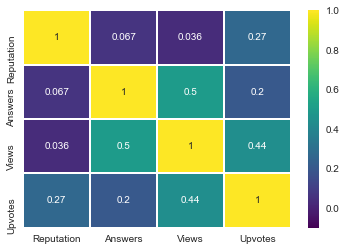

In [12]:
sns.heatmap(train_data.corr(),annot=True,cmap="viridis",vmin=-0.1,vmax=1.0,linewidths=1);

In [13]:
train_data.corr()["Upvotes"][:-1].sort_values(ascending=False)

Views         0.437336
Reputation    0.266710
Answers       0.202033
Name: Upvotes, dtype: float64

In [14]:
pd.DataFrame({"Skewness":train_data.skew(),"Kurtosis":train_data.kurtosis()})

,Skewness,Kurtosis
Reputation,11.230027,198.464137
Answers,3.380169,21.227768
Views,14.370704,425.093309
Upvotes,74.249689,8919.792659


    Skewness:
     -0.5 to -0.5    = Data are fairly Symmetrical
     -1 to -0.5      = Negatively Skewed
      0.5 to 1       = Positively Skewed
      less than -1   = Higly Negatively Skewed
      greater than 1 = Higly Positively Skewed
      
Independent Variabes are Highly Positive Skewed

#### Plot For numerical variables

In [15]:
#sns.pairplot(train_data);

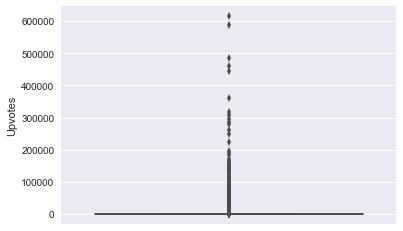

In [16]:
sns.boxplot(train_data["Upvotes"],orient="v");

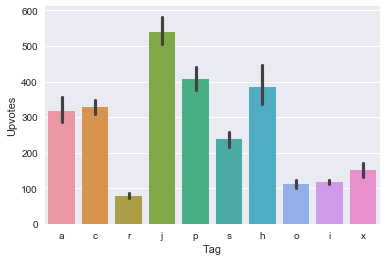

In [17]:

sns.barplot(train_data["Tag"],train_data["Upvotes"]);

#### Check for Missing values

In [18]:
train_data.isnull().sum()


Tag           0
Reputation    0
Answers       0
Views         0
Upvotes       0
dtype: int64

There are no Missing values

#### Outlier Detection

In [19]:
def Outlier_detection(train_data):
    numerical_columns=list(train_data.select_dtypes("int64","float64").columns)
    index=["Total Observations","Lower Limit","Upper Limit","IQR","Number of Outliers","No. of Not outlers","Outlier Percentage"]
    out_df=pd.DataFrame(index=numerical_columns,columns=index)
    for col in numerical_columns:
        Q1,Q3=np.percentile(train_data[col],[25,75])
        IQR=Q3-Q1
        lower_limit=Q1-(1.5*IQR)
        upper_limit=Q3+(1.5*IQR)
        outlier=[]
        No_Outliers=[]
        for i in train_data[col]:
            if (i<lower_limit) | (i>upper_limit):
                outlier.append(i)
        new_df=pd.DataFrame({"Total Observations":len(train_data[col]),"Lower Limit":lower_limit,"Upper Limit":upper_limit,"IQR":IQR,"Number of Outliers":len(outlier),"No. of Not outlers":len(train_data[col])-len(outlier),"Outlier Percentage":(len(outlier)/len(train_data[col]))*100},index=[col])
        out_df.update(new_df)
    return(out_df)

In [20]:
Outlier_detection(train_data)

,Total Observations,Lower Limit,Upper Limit,IQR,Number of Outliers,No. of Not outlers,Outlier Percentage
Reputation,330045,-6972,12372,4836,42864,287181,12.9873
Answers,330045,-2.5,9.5,3,19939,310106,6.0413
Views,330045,-33820,63284,24276,35961,294084,10.8958
Upvotes,330045,-140.5,255.5,99,46943,283102,14.2232


#### Check for Multicollinearity

In [21]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [22]:
y, X = dmatrices("Upvotes ~ Reputation+Answers+Views",data=train_data, return_type='dataframe')

In [23]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [24]:
vif.round(1)

,VIF Factor,features
0,2.3,Intercept
1,1.0,Reputation
2,1.3,Answers
3,1.3,Views


VIF greate than 5 indicate hingh Multicollinearity and there is no Multicollinearity between independent variables in our dataset

#### Feature Encoding

In [25]:
tag=pd.get_dummies(train_data["Tag"],drop_first=True)
numerical_columns=list(train_data.select_dtypes("int64","float64").columns)
new_train=pd.concat([train_data[numerical_columns],tag],axis=1)

#### Prepare Test Data

In [26]:
test_data.drop(["ID","Username"],axis=1,inplace=True)

In [27]:
test_tag=pd.get_dummies(test_data["Tag"],drop_first=True)
numerical_columns=list(test_data.select_dtypes("int64","float64").columns)
new_test=pd.concat([test_data[numerical_columns],test_tag],axis=1)

#### Prepare X and Y

In [28]:
x=new_train.drop(["Upvotes"],axis=1)
y=new_train["Upvotes"]

#### Linear Regression
Model is created for the linear relationship between dependent and independent variable and fits a strainght line closest to all data points reducing the error

##### Pros
* simple and low flexible model
* Quick to compute and can be updated easily with new data
* Relatively easy to understand and model interpretability

##### Cons
* cannot learn complex relationships
* Prone to High Bias
* Difficult to capture non-linear relationships (without first transforming data which can be complicated)

In [29]:
from sklearn.linear_model import LinearRegression
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3,random_state=21)
std_scaler=StandardScaler()
x_train=std_scaler.fit_transform(x_train)
x_test =std_scaler.fit_transform(x_test)

lr=LinearRegression()
lr.fit(x_train,y_train)

pred=lr.predict(x_test)


In [30]:
np.sqrt(mean_squared_error(pred,y_test))

3074.7854228934284

In [33]:
Test_evalu=pd.DataFrame(lr.predict(new_test))
test_eval=pd.concat([test_raw["ID"],Test_evalu],axis=1)
test_eval.rename(columns={0:"Upvotes"},inplace=True)
test_eval.to_csv("test_evaluation.csv",index=False)

RMSE for Test Evaluation: 3543

In [34]:
# https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
#https://zhiyzuo.github.io/Linear-Regression-Diagnostic-in-Python/

#### Polynomial Regression

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
poly_reg=PolynomialFeatures(degree=4)
x_poly=poly_reg.fit_transform(x_train)
lin_reg_1 = linear_model.LassoLars(alpha=0.021,max_iter=200)
lin_reg_1.fit(x_poly, y_train) 
 

LassoLars(alpha=0.021, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=200, normalize=True,
          positive=False, precompute='auto', verbose=False)

In [36]:
pred=poly_reg.fit_transform(x_test) 
pred_val = lin_reg_1.predict(pred)

print(r2_score(y_test, pred_val))

0.9166787651031887


In [37]:
test = std_scaler.fit_transform(new_test)

Test_evalu=pd.DataFrame(lin_reg_1.predict(poly_reg.fit_transform(test)))
test_eval=pd.concat([test_raw["ID"],Test_evalu],axis=1)
test_eval.rename(columns={0:"Upvotes"},inplace=True)
test_eval.to_csv("test_evaluation.csv",index=False)

### Test Evaluation Score: 896.36

#### LassoLars Regression Hyper Tuning

In [38]:
from sklearn.linear_model import Ridge,Lasso
params_lasso={"alpha":(0,0.01,0.015,0.02,0.025,0.03,0.05,0.06,0.07),"max_iter":(100,150,200,250,300,450,500,600,700,800)}
lasso_model=linear_model.LassoLars()

xgrid=RandomizedSearchCV(lasso_model,param_distributions=params_lasso,scoring="neg_mean_squared_error",n_jobs=-1,cv=5)

xgrid.fit(x_poly,y_train)

print("Best neg_mean_squared_error : %f using %s" % (xgrid.best_score_,xgrid.best_params_))


Best neg_mean_squared_error : -5504434.382260 using {'max_iter': 450, 'alpha': 0.06}


In [39]:

lin_reg_1 = linear_model.LassoLars(alpha=0.06,max_iter=450)
lin_reg_1.fit(x_poly, y_train)
pred=poly_reg.fit_transform(x_test) 
pred_val = lin_reg_1.predict(pred)

print(r2_score(y_test, pred_val))


0.9195953159787648


In [38]:
test = std_scaler.fit_transform(new_test)

Test_evalu=pd.DataFrame(lin_reg_1.predict(poly_reg.fit_transform(test)))
test_eval=pd.concat([test_raw["ID"],Test_evalu],axis=1)
test_eval.rename(columns={0:"Upvotes"},inplace=True)
test_eval.to_csv("test_evaluation.csv",index=False)

### Test Evaluation Score: 890.041

#### LassoLars Regression Hyper Tuning

In [47]:
from sklearn.linear_model import Ridge,Lasso
params_ridge={"alpha":(0,0.01,0.015,0.02,0.025,0.03,0.05,0.06,0.065,0.07,0.08,0.09),"max_iter":(100,150,200,250,300,400,450,500,600,800)}
ridge_model=linear_model.LassoLars()

rgrid=RandomizedSearchCV(ridge_model,param_distributions=params_ridge,scoring="neg_mean_squared_error",n_jobs=-1,cv=5)

rgrid.fit(x_poly,y_train)

print("Best neg_mean_squared_error : %f using %s" % (rgrid.best_score_,rgrid.best_params_))


Best neg_mean_squared_error : -1193805.608578 using {'max_iter': 400, 'alpha': 0.02}


In [55]:
lin_reg_1 = linear_model.LassoLars(alpha=0.02,max_iter=400)
lin_reg_1.fit(x_poly, y_train)
pred=poly_reg.fit_transform(x_test) 
pred_val = lin_reg_1.predict(pred)

print(r2_score(y_test, pred_val))


0.9168188033959582


In [57]:
test = std_scaler.fit_transform(new_test)

Test_evalu=pd.DataFrame(lin_reg_1.predict(poly_reg.fit_transform(test)))
test_eval=pd.concat([test_raw["ID"],Test_evalu],axis=1)
test_eval.rename(columns={0:"Upvotes"},inplace=True)
test_eval.to_csv("test_evaluation.csv",index=False)

### Test Evaluation score: 897.88